In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from monk import prep
from monk import pair
import freud
import ex_render

In [2]:
def render_sim(sim):
    return ex_render.render_disk_frame(frame=sim.state.get_snapshot())

def render_movie(gsd_file):
    ex_render.display_movie(frame_gen=ex_render.render_disk_frame, gsd_file=gsd_file)

In [26]:
def gen_highT_state():
    seed = 1000
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(cpu, seed=seed)
    N = 64
    rng = prep.init_rng(seed + 1)
    L = prep.len_from_phi(N, 1.15, dim=2)
    snap = prep.approx_euclidean_snapshot(N, L, rng, dim=2, ratios=[60,40], diams=[1.0, 0.88])

    sim.create_state_from_snapshot(snap)

    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), 1.0, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)

    sim.operations.integrator = integrator

    sim.run(0)

    print(thermodynamic_properties.pressure)

    for i in range(10):

        sim.run(400_001, True)

        print(i, thermodynamic_properties.pressure)

    hoomd.write.GSD.write(sim.state, "init-state.gsd")

    return render_sim(sim)
    

In [85]:
def dynamic_gsd(temp, seed):
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(cpu, seed=seed)

    sim.create_state_from_gsd("init-state.gsd")
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temp, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.run(400_000)

    writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="dynamic-image.gsd", mode="wb", filter=hoomd.filter.All(), dynamic=["property", "momentum"])
    writer_std = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="static-image.gsd", mode="wb", filter=hoomd.filter.All())
    sim.operations.writers.clear()
    sim.operations.writers.append(writer)
    sim.operations.writers.append(writer_std)

    sim.operations.integrator = integrator

    sim.run(4_000_001, True)

In [36]:
def simulation_run_msd(temp, seed):
    cpu = hoomd.device.CPU()
    sim = hoomd.Simulation(cpu, seed=seed)

    sim.create_state_from_gsd("init-state.gsd")
    sim.always_compute_pressure = True
    thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
        filter=hoomd.filter.All())
    sim.operations.computes.append(thermodynamic_properties)
    
    integrator = hoomd.md.Integrator(dt=0.0025)
    tree = hoomd.md.nlist.Tree(0.3)
    lj = pair.KA_LJ(tree)
    nvt = hoomd.md.methods.NVT(hoomd.filter.All(), temp, 1.0)
    integrator.forces = [lj]
    integrator.methods = [nvt]

    sim.run(400_000)

    writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(400), filename="long-test.gsd", mode="wb", filter=hoomd.filter.All())
    sim.operations.writers.clear()
    sim.operations.writers.append(writer)

    sim.operations.integrator = integrator

    sim.run(4_000_001, True)

    msd = freud.msd.MSD()

    pos = []

    for frame in gsd.hoomd.open("long-test.gsd"):
        pos.append(frame.particles.position)

    msd.compute(pos)

    return msd.msd

27.915922693513103
0 9.812412983938028
1 9.210653618436265
2 6.777905718188988
3 7.296973108132227
4 7.903284585946382
5 8.603639920300607
6 7.2155748923097836
7 8.795649386044047
8 7.796657236011115
9 8.405486316222534


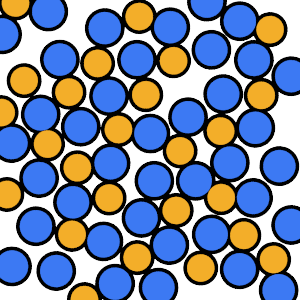

In [27]:
gen_highT_state()

In [37]:
temps = np.linspace(0.05, 0.7, 14)
msds = []

for idx, temp in enumerate(temps):
    print(idx, temp)
    msds.append(simulation_run_msd(temp, idx))

0 0.05
1 0.1
2 0.15
3 0.2
4 0.25
5 0.3
6 0.35
7 0.39999999999999997
8 0.44999999999999996
9 0.49999999999999994
10 0.5499999999999999
11 0.6
12 0.65
13 0.7


(0.4, 20)

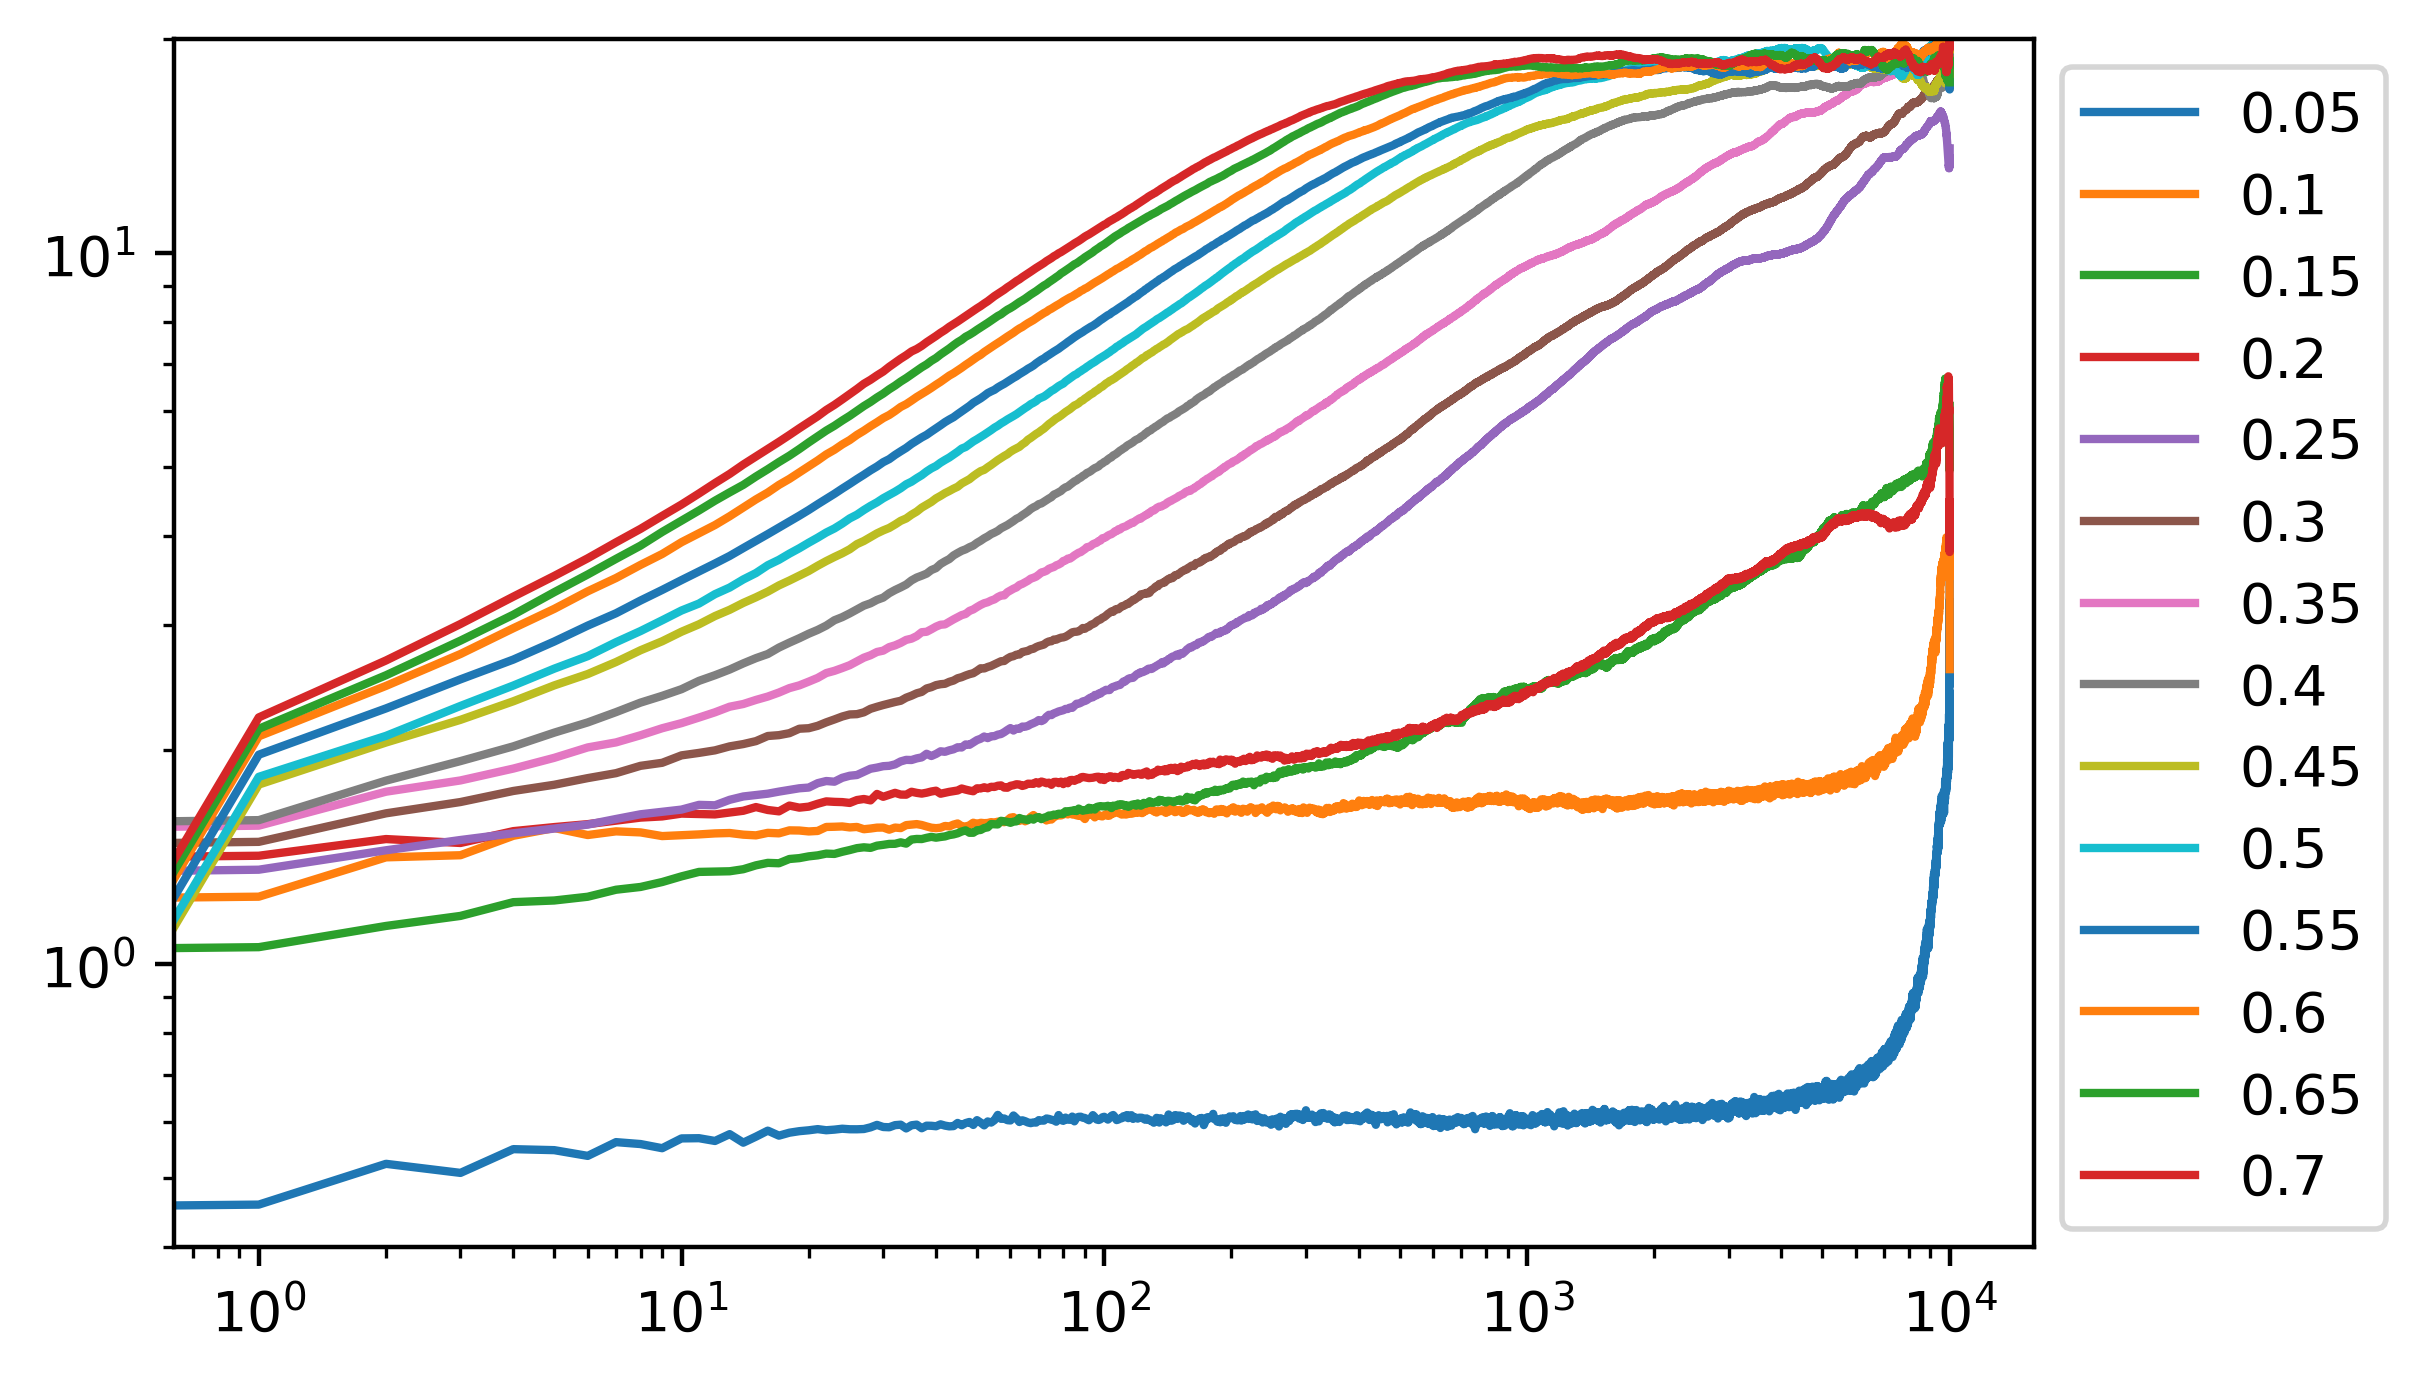

In [48]:
plt.figure(dpi=200)
for temp, msd in zip(temps, msds):
    plt.plot(msd, label=f"{temp:.2}")
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(4e-1, 20)

(0.1, 20.0)

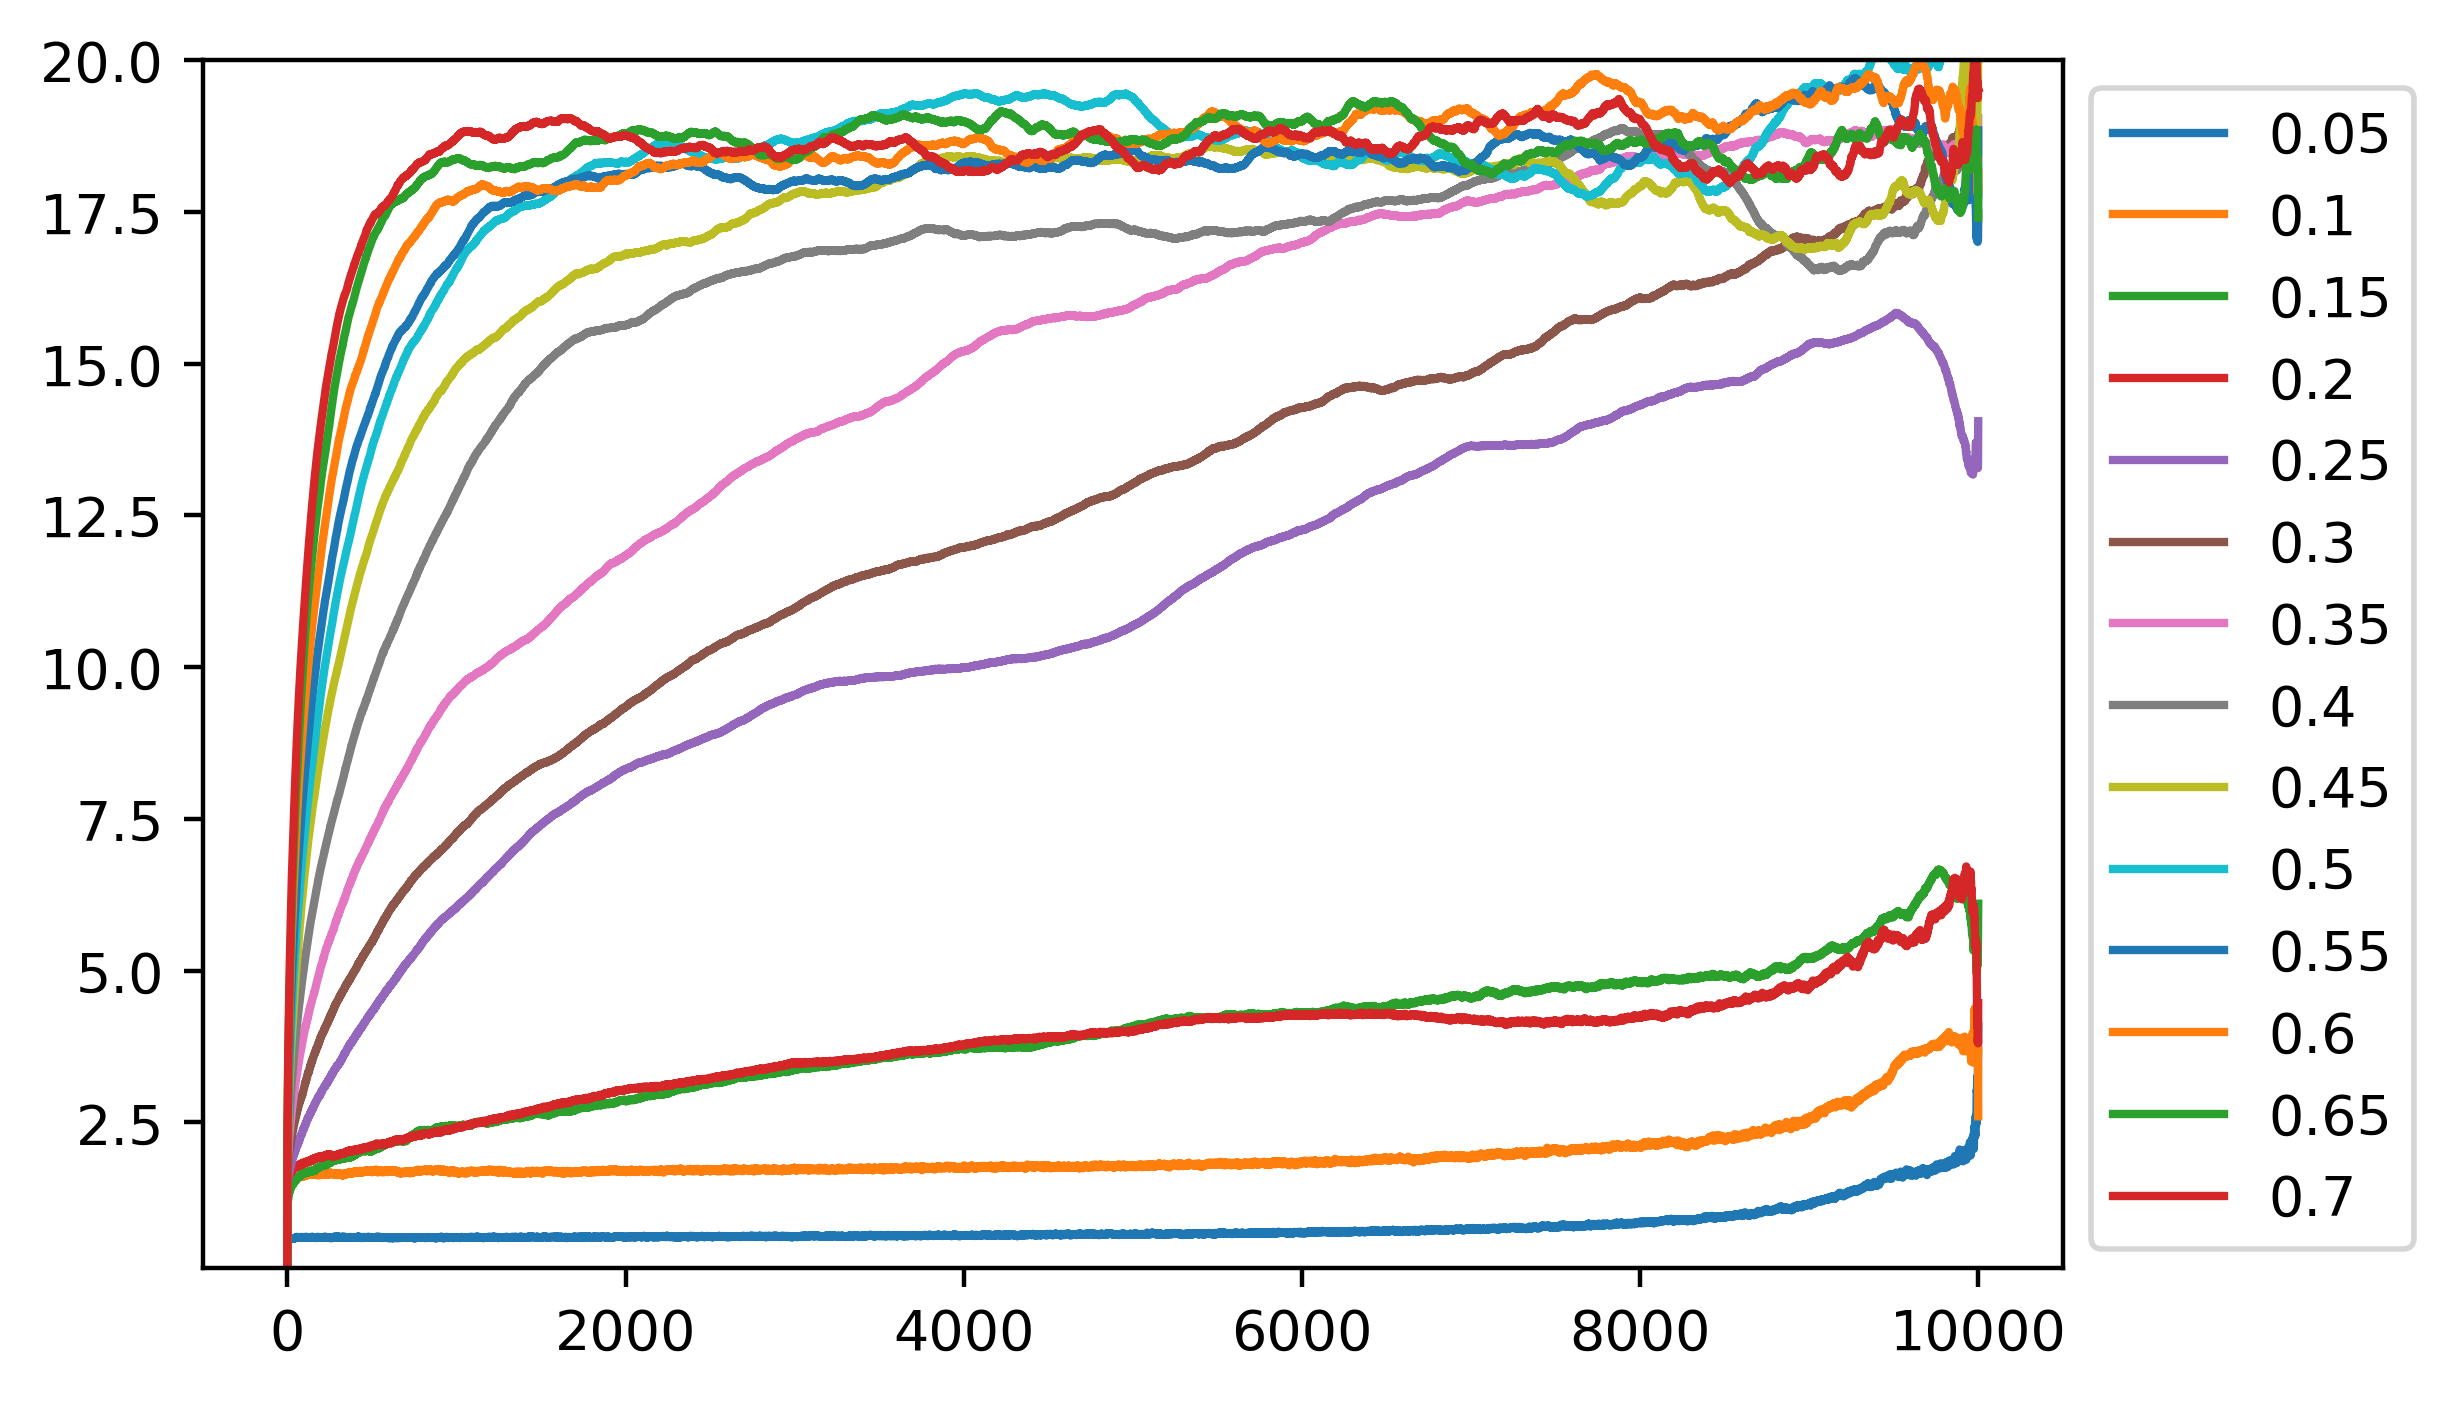

In [46]:
plt.figure(dpi=200)
for temp, msd in zip(temps, msds):
    plt.plot(msd, label=f"{temp:.2}")
plt.legend(bbox_to_anchor=(1,1))
plt.ylim(1e-1, 20)

In [86]:
dynamic_gsd(1.0, 2324)

In [98]:
traj = gsd.hoomd.open("dynamic-image.gsd")

box = freud.Box.from_box(traj[0].configuration.box)

In [99]:
msd = freud.msd.MSD()

pos = []

for frame in traj[::10]:
    pos.append(box.unwrap(frame.particles.position, frame.particles.image))

msd.compute(pos);

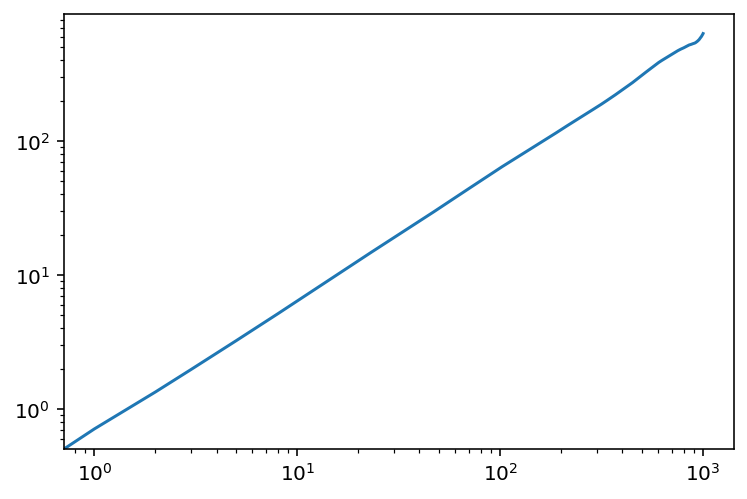

In [100]:
plt.plot(msd.msd)
plt.yscale('log')
plt.xscale('log')